# Classifying Electrocardiogram signals with wavelets and lightGBM

In the following we will classify ECG signals using the [MIT-BIH Arrthymia database](https://ecg.mit.edu/) compiled by MIT.

According to the description, the dataset contains 48 half-hour exceprts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrthymia Laboratory between 1975 and 1979.
The researchers of MIT chose 23 recordings at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.
Additional info for this dataset can be found [here](https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm).

## Libraries

In [2]:
from utils import feature_extractor

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils import compute_sample_weight
import lightgbm as lgb

## Data read

In [3]:
# Last column is the target
dfl = pd.read_csv('./mitbih_train.csv', header = None)
dft = pd.read_csv('./mitbih_test.csv',  header = None)

print(f'Train set shape: {dfl.shape[0]} x {dfl.shape[1]}')
print(f'Test set shape:\t {dft.shape[0]} x {dft.shape[1]}')

print('Train set class balance')
for target in np.unique(dfl.iloc[:, -1]):
    p = (dfl.iloc[:, -1] == target).sum() / dfl.shape[0] * 100
    print(f'Class {target}: {p:2.2f} %')

print('Test set class balance')
for target in np.unique(dft.iloc[:, -1]):
    p = (dft.iloc[:, -1] == target).sum() / dft.shape[0] * 100
    print(f'Class {target}: {p:2.2f} %')

Train set shape: 87554 x 188
Test set shape:	 21892 x 188
Train set class balance
Class 0.0: 82.77 %
Class 1.0: 2.54 %
Class 2.0: 6.61 %
Class 3.0: 0.73 %
Class 4.0: 7.35 %
Test set class balance
Class 0.0: 82.76 %
Class 1.0: 2.54 %
Class 2.0: 6.61 %
Class 3.0: 0.74 %
Class 4.0: 7.35 %


Let's plot some random examples

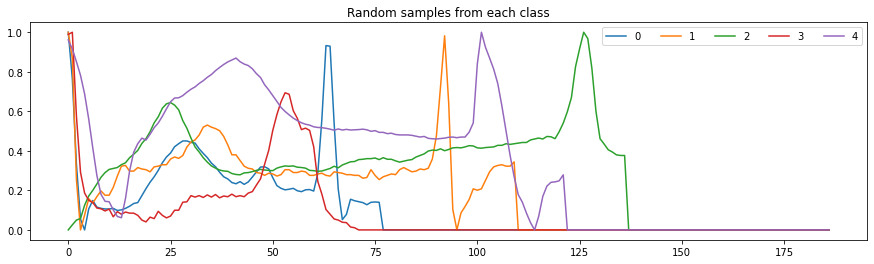

In [4]:
plt.figure(figsize = (15, 4))

for target in np.unique(dfl.iloc[:, -1]):
    
    # Grab indices of samples in this class
    class_samples = np.where(dfl.iloc[:, -1] == target)[0]
    
    # Pick one at random
    idx = np.random.randint(0, class_samples.shape[0], size = (1, ))
    
    # Plot it
    sample = dfl.iloc[class_samples[idx], :-1].values.flatten()
    plt.plot(sample, label = int(target))
    
plt.legend(loc = 1, ncol = 5)
plt.title('Random samples from each class')
plt.show()

## Preprocessing

Some signals are zero padded. Trailing zeros will be removed and a discrete wavelet transformation will be applied.
From each sub-band several features will be extracted.
With the new (tabular) dataset a classifier will be trained.
This all takes place in the utils modude

In [ ]:
# Extract features from wavelet transform
Xl = feature_extractor(dfl.iloc[:, :-1].values, noLevels = 4, waveletName = 'haar')
Xt = feature_extractor(dft.iloc[:, :-1].values, noLevels = 4, waveletName = 'haar')

# Grab target column
yl = dfl.iloc[:, -1]
yt = dft.iloc[:, -1]

# Merge to make new dataset
dfl = pd.concat([Xl, yl], axis = 1)
dft = pd.concat([Xt, yt], axis = 1)

In [11]:
print(f'Train set shape: {dfl.shape[0]} x {dfl.shape[1]}')
print(f'Test set shape:\t {dft.shape[0]} x {dft.shape[1]}')

Train set shape: 87554 x 91
Test set shape:	 21892 x 91


In [12]:
print('Train set Missing values [%]')
v = (dfl.isnull().sum() / dfl.shape[0] * 100).sort_values(ascending = False).head(5)
print(v)

print('\nTest set Missing values [%]')
v = (dft.isnull().sum() / dft.shape[0] * 100).sort_values(ascending = False).head(10)
print(v)

Train set Missing values [%]
kurtosis4               0.751536
skewness4               0.127921
kurtosis3               0.025127
benford_correlation4    0.001142
benford_correlation3    0.000000
dtype: float64

Test set Missing values [%]
kurtosis4               0.872465
skewness4               0.200987
kurtosis3               0.031975
mean_abs_change4        0.009136
skewness3               0.009136
kurtosis2               0.004568
root_mean_square2       0.000000
benford_correlation3    0.000000
mean_abs_change3        0.000000
mean3                   0.000000
dtype: float64


There's a small percentrage of missing values from the extracted features. We will set them to zero

In [13]:
dfl.fillna(0, inplace = True)
dft.fillna(0, inplace = True)

## Modelling

In [14]:
# Split X, y
Xl, Xt = dfl.iloc[:, :-1].values, dft.iloc[:, :-1].values
yl, yt = dfl.iloc[:, -1].astype(int).values, dft.iloc[:, -1].astype(int).values

In general with LGB, we need to tune:
* the learning rate of the gradient (learning_rate), 
* the max depth of each tree (max_depth), 
* Minimum loss reduction required to make a further partition on a leaf node of the tree (min_split_gain), 
* the number of points to randomly sample from the whole training set for each tree creation (subsample), 
* and the number of features to randomly sample from the whole training set during the creation of each node for each tree (colsample_bytree).

With (n) being the number of samples in the learning set, and (d) the number of predictors, the hyperparameter grid will be:
* learning_rate = 0.01, 0.02, 0.03, 0.04, 0.05
* max_depth = 3,5,10
* min_split_gain = 0, 0.1, 0.2
* subsample = 0.6 n , 0.8 n, 1 n
* colsample_bytree = 0.5 d, 0.8 d, 1 

Before the hyperparameter tuning, we will run a CV procedure with the default parameters (apart from the number of trees), to see if the features extracted with the DWT have any potential.
We will set the number of trees to a large (but still tractable) value: 1000.
The rest of the hyperparameters will remain to their default values for this run

In [15]:
no_CV  = 5 # No. folds
nt     = 1000 # No trees
skf    = StratifiedKFold(n_splits = no_CV, random_state = 1, shuffle = True)
aurocs = []

for fold, (lidx, vidx) in enumerate(skf.split(Xl, yl)):
    
    # Split train / validation
    X_train, y_train = Xl[lidx, :], yl[lidx]
    X_test, y_test   = Xl[vidx, :], yl[vidx]
    
    # Estimate class weights
    w_train = compute_sample_weight(y = y_train, class_weight = 'balanced')
    w_test  = compute_sample_weight(y = y_test,   class_weight = 'balanced')
    
    # Make the classifier (default hyperparameters apart from the number of trees)
    clf = lgb.LGBMClassifier(class_weight  = 'balanced', 
                             boosting_type = 'dart', 
                             n_estimators  = nt,
                             objective     = 'multi_logloss')
    
    # Fit
    clf.fit(X_train, y_train, sample_weight = w_train) 
    
    # Predict
    y_hat = clf.predict_proba(X_test)   
    
    # Evaluate metric
    auroc = roc_auc_score(y_test, y_hat, multi_class = 'ovr', sample_weight = w_test)
    aurocs.append(auroc)
    
    # Print result
    print(f'Fold {fold + 1} Test set AUROC (w-ovr): {np.round(auroc, 4)}')


# Compute average and std
avg = np.mean(aurocs)
ci  = 2.776 * np.std(aurocs) / np.sqrt(no_CV) # 4 Degrees of freedom
print(f'95% Confidence Interval: {avg:1.4f} +- {ci:1.4f}')

Fold 1 Test set AUROC (w-ovr): 0.9929
Fold 2 Test set AUROC (w-ovr): 0.991
Fold 3 Test set AUROC (w-ovr): 0.9939
Fold 4 Test set AUROC (w-ovr): 0.9938
Fold 5 Test set AUROC (w-ovr): 0.9919
95% Confidence Interval: 0.9927 +- 0.0014


Apparently, there is no reason to do any hyperparameter tuning. The default values provide very good results.
Let's try the prediction set

In [16]:
# Compute class weights
wl = compute_sample_weight(y = yl, class_weight = 'balanced')
wt = compute_sample_weight(y = yt, class_weight = 'balanced')

clf = lgb.LGBMClassifier(class_weight  = 'balanced', 
                         boosting_type = 'dart', 
                         n_estimators  = nt,
                         objective     = 'multi_logloss')

# Fit the model
clf.fit(Xl, yl, sample_weight = wl) 

# Predict
y_hat = clf.predict_proba(Xt)   
    
# Evaluate metric
auroc = roc_auc_score(yt, y_hat, multi_class = 'ovr', sample_weight = wt)

# Print result
print(f'Prediction set AUROC (w-ovr): {auroc:2.4f}')

Prediction set AUROC (w-ovr): 0.9894
